# Convolution Visualization (kernels & activations)

This notebook contains helper code to visualize convolutional kernels (filters) and intermediate feature maps (activations) for the SimpleCNN used in the project.
It is standalone: it re-defines the model architecture used in `MNIST-classifier.ipynb`, loads the MNIST test set (from `./MNIST-Data`), and — if available — loads `best_mnist_cnn.pth` weights.

Run the cells in order.

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision

class Config:
    DATA_ROOT = './MNIST-Data'
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = 64
    MODEL_SAVE_PATH = 'best_mnist_cnn.pth'

print(f'Using device: {Config.DEVICE}')

Using device: cpu


In [2]:
# Re-declare SimpleCNN exactly as used in the training notebook so saved weights are compatible
class SimpleCNN(nn.Module):
    """Convolutional Neural Network (CNN) for MNIST classification."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print('SimpleCNN defined')

SimpleCNN defined


In [3]:
# Data: load MNIST test set (we only need a few examples for visualization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print(f'Loading MNIST from {Config.DATA_ROOT}...')
test_dataset = MNIST(root=Config.DATA_ROOT, train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0)
print('Test dataset loaded; example count =', len(test_dataset))

Loading MNIST from ./MNIST-Data...
Test dataset loaded; example count = 10000


In [4]:
# Visualization helpers: kernels and activations
import numpy as np

def visualize_kernels(conv_layer, ncols=8, cmap='gray', figsize=(6,6)):
    """Show learned convolution kernels from a nn.Conv2d layer.
    conv_layer: nn.Conv2d module (e.g., model.conv1)
    """
    weights = conv_layer.weight.detach().cpu()  # (out_ch, in_ch, kH, kW)
    out_ch, in_ch, kH, kW = weights.shape

    if in_ch > 1:
        imgs = weights.mean(dim=1, keepdim=False)
    else:
        imgs = weights[:, 0, :, :]

    imgs_min = imgs.view(out_ch, -1).min(dim=1)[0].view(-1, 1, 1)
    imgs_max = imgs.view(out_ch, -1).max(dim=1)[0].view(-1, 1, 1)
    imgs_norm = (imgs - imgs_min) / (imgs_max - imgs_min + 1e-8)

    grid = torchvision.utils.make_grid(imgs_norm.unsqueeze(1), nrow=ncols, padding=1)
    npimg = grid.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1,2,0)).squeeze(), cmap=cmap)
    plt.axis('off')
    plt.title(f'Kernels: {out_ch} filters, size {kH}x{kW}')
    plt.show()

def visualize_activations(model, layer_module, input_tensor, device=None, ncols=8, figsize=(10,4), cmap='viridis'):
    """Visualize feature maps produced by `layer_module` for a single input image.
    - model: PyTorch model
    - layer_module: module to hook (e.g., model.conv1)
    - input_tensor: (C,H,W) tensor, unbatched
    """
    device = device or next(model.parameters()).device
    activations = {}

    def hook(module, input, output):
        activations['out'] = output.detach().cpu()

    handle = layer_module.register_forward_hook(hook)
    model.eval()
    with torch.no_grad():
        x = input_tensor.unsqueeze(0).to(device)
        _ = model(x)

    handle.remove()

    if 'out' not in activations:
        raise RuntimeError('Hook did not capture activations.')

    fmap = activations['out'].squeeze(0)  # (out_ch, H, W)
    out_ch, H, W = fmap.shape

    fmap_min = fmap.view(out_ch, -1).min(dim=1)[0].view(-1,1,1)
    fmap_max = fmap.view(out_ch, -1).max(dim=1)[0].view(-1,1,1)
    fmap_norm = (fmap - fmap_min) / (fmap_max - fmap_min + 1e-8)

    grid = torchvision.utils.make_grid(fmap_norm.unsqueeze(1), nrow=ncols, padding=1)
    npimg = grid.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1,2,0)).squeeze(), cmap=cmap)
    plt.axis('off')
    plt.title(f'Activations: {out_ch} feature maps, size {H}x{W}')
    plt.show()

Loaded weights from best_mnist_cnn.pth


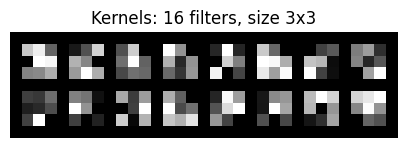

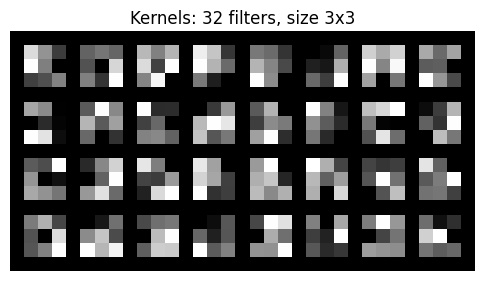

Sample label: 4


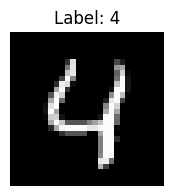

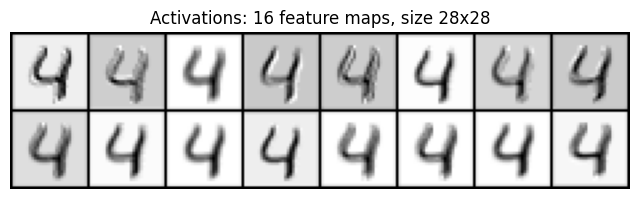

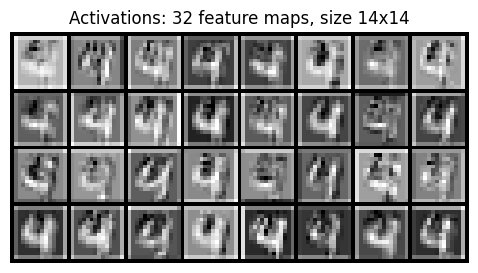

In [7]:
# Example usage: build model, try to load saved weights, visualize kernels and activations for one test image
model = SimpleCNN().to(Config.DEVICE)
if os.path.exists(Config.MODEL_SAVE_PATH):
    try:
        state = torch.load(Config.MODEL_SAVE_PATH, map_location=Config.DEVICE)
        model.load_state_dict(state)
        print(f'Loaded weights from {Config.MODEL_SAVE_PATH}')
    except Exception as e:
        print('Could not load weights:', e)
else:
    print(f'No checkpoint found at {Config.MODEL_SAVE_PATH}; using randomly initialized model')

# Visualize conv1 kernels
visualize_kernels(model.conv1, ncols=8, figsize=(5,5))

# Visualize conv2 kernels (these are averaged over input channels for display)
visualize_kernels(model.conv2, ncols=8, figsize=(6,6))

# Take one sample from test_loader and visualize activations
images, labels = next(iter(test_loader))
img = images[4]  # shape [1,28,28]
label = labels[4].item()
print('Sample label:', label)

# show the input image (unnormalized for display)
mean = 0.1307; std = 0.3081
img_disp = img.squeeze(0).cpu() * std + mean
plt.figure(figsize=(2,2)); plt.imshow(img_disp.numpy(), cmap='gray'); plt.axis('off'); plt.title(f'Label: {label}')

# Visualize activations for conv1 and conv2
visualize_activations(model, model.conv1, img, device=Config.DEVICE, ncols=8, figsize=(8,3))
visualize_activations(model, model.conv2, img, device=Config.DEVICE, ncols=8, figsize=(10,3))